# Machine Learning II Project - UrbanSound8K dataset

#### Work done by: Ana Pinto (202105085) |  Miguel Santos (202105289) | Tomás Rodrigues (202107937)


### Index

1. [Introduction](#Intro)<br>
2. [Data Analysis](#Analysis)<br>
     2.1 [Loading data](#Loading)<br>
     2.2 [Data Visualization](#Visualization)<br>
          2.2.1 [Class Distribution](#Class-Distribution)<br>
          2.2.1 [Missing Values](#Missing-Values)<br>
          2.2.2 [Audio Features](#Audio)<br>
          
3. [Data Preprocessing For MLP](#Preprocessing)<br>
     3.1 [MFCC MLP](#MFCC)<br>
4. [Data Preprocessing For CNN](#Preprocessing-CNN)<br>
     4.1 [MFCC CNN](#MFCC-CNN)<br>

<a id='Intro'></a>


## 1. Introduction

These notebooks are for the project of "Aprendizagem Computacional II" of the University of Porto. The objective of this practice is to apply the knowledge acquired in the course to a real problem. In this case, the problem is the classification of sounds from the UrbanSound8K dataset.
This classification problem involves categorizing sound excerpts into distinct classes based on their acoustic features. The UrbanSound8K dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The objective is to build classifiers capable of accurately identifying the class to which an unseen sound excerpt belongs.

We choose to use the MLP classifier and the CNN classifier to solve this problem.


<a id='Analysis'></a>

## 2. Data analysis

<a id="Loading"></a>
### 2.1 Loading data

Imports that are needed for the code below

In [15]:
import librosa
import pickle as pki
import pandas as pd
import os
from pydub import AudioSegment
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Paths to the dataset and to the metadata file

In [16]:
path_metadata = "Urbansound8k/metadata/UrbanSound8K.csv"
path_sons= "Urbansound8k/audio"

<a id='Visualization'></a>

### 2.2 Data Visualization

Reading the metadata file

In [17]:
metadata = pd.read_csv(path_metadata)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<a id='Class-Distribution'></a>
#### 2.2.1 Class Distribution

Distribution of the classes

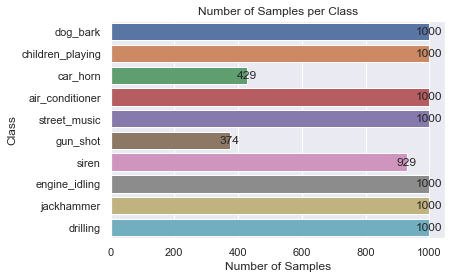

In [18]:
sns.set(style="darkgrid")
ax = sns.countplot(y=metadata['class'], orient='v')

plt.title('Number of Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class')

for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), ha='center', va='center')

plt.show()

Checking class distribution of each fold

In [19]:
# Checking class distribution of each fold

class_folds = []
for i in range(1,11):
    class_folds.append(metadata[metadata.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(class_folds)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,dog_bark,street_music,air_conditioner,children_playing,drilling,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


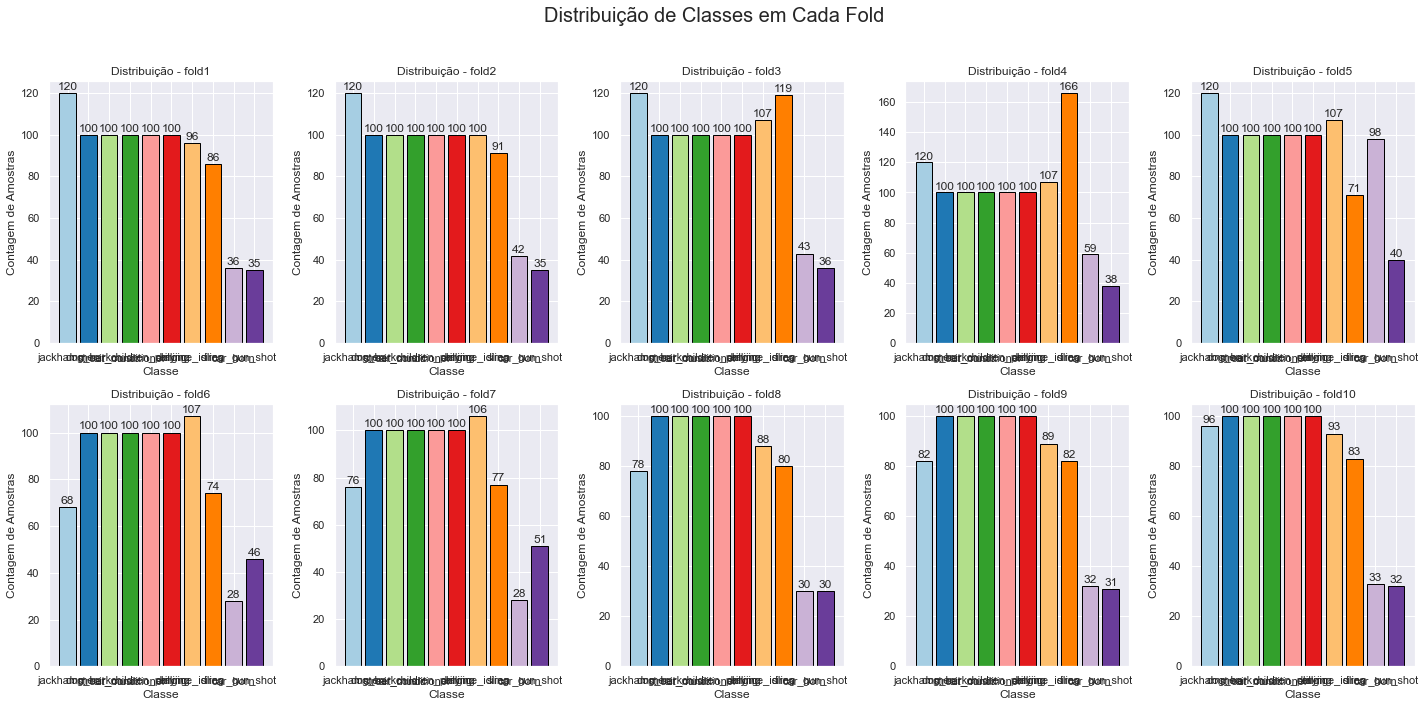

In [20]:
df = pd.DataFrame(class_distribution)

classes = df.columns[1:]
colors = plt.cm.Paired(range(len(classes)))

# Configuração dos subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Distribuição de Classes em Cada Fold', fontsize=20)

# Crie um gráfico de barras para cada fold
for i, fold in enumerate(df['index']):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    ax.bar(classes, df[df['index'] == fold].iloc[:, 1:].values.flatten(), color=colors, width=0.8, edgecolor='black')
    ax.set_title(f'Distribuição - {fold}')
    ax.set_xlabel('Classe')
    ax.set_ylabel('Contagem de Amostras')
    
    for bar, count in zip(ax.patches, df[df['index'] == fold].iloc[:, 1:].values.flatten()):
        ax.annotate(f'{count}', (bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5),
                ha='center', va='bottom')


plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()




<a id='#Missing-Values'></a>

#### 2.2.2 Missing Values
Verifying if all files exist in the metadata and if exists missing values

In [21]:
def check_metadata_files(metadata_file, fold_files):
    metadata = metadata_file
    
    metadata_files = metadata['slice_file_name'].tolist()
    
    fold_files = [file for file in fold_files if file.endswith('.wav')]
    # Check if all the files in the folds are present in the metadata
    for file in fold_files:
        if file not in metadata_files:
            return f'The file {file} is not present in the metadata'
    
    return 'All the files in the folds are present in the metadata'

# Get the list of files in the folds
fold_files = []
for i in range(1, 11):
    fold_path = os.path.join(path_sons, f'fold{i}')
    fold_files += os.listdir(fold_path)

# Check if all the files in the folds are present in the metadata
print(check_metadata_files(metadata, fold_files))


# Check if the dataset has any missing values
print(metadata.isnull().sum())


All the files in the folds are present in the metadata
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


<a id='Audio'></a>

#### 2.2.3 Audio Features

#### Sampling Rate, Bit Depth, Duration
 
Sampling rate and bit depth are two of the most important elements when discretizing audio signals. They are related to analogue to digital conversion. Sampling rate decides how frequently it will take samples, and bit depth decides how detailed it will take samples.

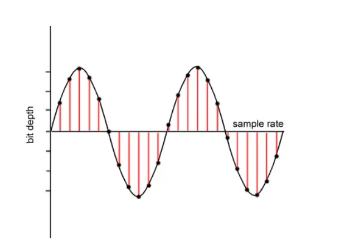

Fig. 1: Sampling rate and bit depth

To have the data all on the same scales, let's see what the most common values are.


Verifying the sampling rate of all files

In [22]:

sample_rates = {}

# Folds loop
for i in range(1, 11):  # 10 folds
    fold_path = os.path.join(path_sons, f"fold{i}")

    # Loop over all the files in the fold
    files = librosa.util.find_files(fold_path)
    for filename in files:
        if filename.endswith(".wav"):
            sr = librosa.get_samplerate(filename)
            if sr in sample_rates:
                sample_rates[sr] += 1
            else:
                sample_rates[sr] = 1


print(f'The Sample rate most common is  {max(sample_rates, key=sample_rates.get)} Hz')


The Sample rate most common is  44100 Hz


Verifying the bit depth of the files

In [23]:
bit_depths = {}

# Loop folds
for i in range(1, 11):  
    fold_path = os.path.join(path_sons, f"fold{i}")

    # Loop over all the files in the fold
    files = librosa.util.find_files(fold_path)
    for filename in files:
        if filename.endswith(".wav"):
            info = sf.info(filename)
            bit_depth = info.subtype[-2:]  # last 2 caracteres of string 'subtype'
            
            if bit_depth in bit_depths:
                bit_depths[bit_depth] += 1
            else:
                bit_depths[bit_depth] = 1
                
max_bit_depth = max(bit_depths, key=bit_depths.get)
print(f'The most common bit depth is {max_bit_depth} bits')

The most common bit depth is 16 bits


Verifying the duration of the files

In [24]:
# list for storing the durations
durations = []

# Loop folds
for i in range(1, 11): 
    fold_path = os.path.join(path_sons, f"fold{i}")

    # Loop over all the files in the fold
    files = librosa.util.find_files(fold_path)
    for filename in files:
        if filename.endswith(".wav"):
            # load the audio file
            y, sr = librosa.load(filename, sr=None)

            # calculate duration
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)

# calculate average duration
average_duration = sum(durations) / len(durations)

print(f'The average length of the audios is {average_duration} segundos.')

The average length of the audios is 3.6075218292463345 segundos.


<a id='Preprocessing'></a>

## 3. Pre-processing for MLP Classifier

According to the analysis above, we will:
- Resample all files to 22050 Hz -> We reduced it because there would be too much information for the mlp because the matrix
would be very large and would have a very high computational cost

- Convert all files to 16-bit
- Trim all files to 4 seconds

Function to read the audio file and return the audio array with the new sampling rate, bit depth and duration.

<b>Feature extraction</b> of Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples.

<a id='MFCC'></a>

### 3.1 MFCC

MFCC is a feature extraction technique widely used in speech and audio processing. Are used to represent the spectral characteristics of sound in a way that is well-suited for various machine learning tasks.

In simpler terms, MFCCs are a set of coefficients that capture the shape of the power spectrum of a sound signal. They are derived by first transforming the raw audio signal into a frequency domain using a technique like the Discrete Fourier Transform (DFT), and then applying the mel-scale to approximate the human auditory perception of sound frequency. Finally, cepstral coefficients are computed from the mel-scaled spectrum.
The main difference is that a spectrogram uses a linear spaced frequency scale (so each frequency bin is spaced an equal number of Hertz apart), whereas an MFCC uses a quasi-logarithmic spaced frequency scale, which is more similar to how the human auditory system processes sounds.

https://www.analyticsvidhya.com/blog/2021/06/mfcc-technique-for-speech-recognition/

In [25]:
# 
sons_meta =pd.read_csv(path_metadata)
sons_meta= sons_meta.set_index("slice_file_name")
sons_meta.loc['100032-3-0-0.wav'][-1]

def pre_procesing(files,csr,sons_meta):
    pad_ms = 4000  # Add here the fix length you want (in milliseconds)
    data=[]
    label=[]
    counter=0
    num=len(files)
    for f in files:
        if f.endswith(".wav"):
            nf, sr = sf.read(f)
            new_path = "new"
            sf.write(new_path, nf, sr, format="wav")

            audio = AudioSegment.from_file(new_path,format="wav")
            audio = audio.set_sample_width(2)

            padded = audio + AudioSegment.silent(duration=max(0, pad_ms - len(audio)))
            padded.export(new_path, format='wav')
            y, sr = librosa.load(new_path, sr=csr, duration=4.0)
            y = librosa.feature.mfcc(y=y, sr=sr)
            y = librosa.util.normalize(y)
            
            label.append(sons_meta.loc[os.path.basename(f)][-1])
            data.append((y))
            counter +=1
    return data, label



Code to apply the function to all files

In [ ]:
dataset=[]
for i in range(10):
    root=path_sons + "/fold" + str(i+1)
    print(root)
    files= librosa.util.find_files(root)
    data,label=pre_procesing(files,22050,sons_meta)
    dataset.append([data,label])
    print("fold "+str(i+1)+" done")

Saving the dataset to a pickle file to use in the MLP classifier

In [ ]:
with open('dataset_mlp.pkl', 'wb') as file:
    pickle.dump(dataset, file)

<a id='Preprocessing-CNN'></a>

## 4. Pre-processing for CNN Classifier

According to the analysis above, we will:
- Resample all files to 44100 Hz -> At CNN the cost would be the same so we kept the most common values
- Convert all files to 16-bit
- Trim all files to 4 seconds

<a id='MFCC-CNN'> </a>

### 4.1 MFCC CNN

Code to apply the function pre_procesing to all files with the correct atributtes

In [ ]:
dataset=[]
for i in range(10):
    root=path_sons + "/fold" + str(i+1)
    files= librosa.util.find_files(root)
    data,label=pre_procesing(files,44100,sons_meta)
    dataset.append([data,label])

Saving the dataset to a pickle file to use in the CNN classifier

In [ ]:
with open('dataset_cnn.pkl', 'wb') as file:
    pickle.dump(dataset, file)